In [1]:
# Imports
import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import *
import matplotlib.pyplot as plt
from IPython.display import display, Latex

#repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml"
repo_path = "/sdf/group/rubin/repo/main/"
butler = Butler(repo_path)
registry = butler.registry

# Pick a sensor
# Interesting sensors: 9 (C15/C16), 31 (C10) 
sensor = "R03_S12"
# (9, 23, 31, 83, 112, 136)
det = 23
collections=["u/abrought/BF/2023.09.15/run_13248/R03-S12/corrected.fluxConserving"]

dataset_refs = list(registry.queryDatasets(datasetType="gridSpotSrc", 
                                           collections=collections) )
ref = dataset_refs[6]
src = butler.get("gridSpotSrc", dataId=ref.dataId, collections=collections)
raw = src = butler.get("raw", dataId=ref.dataId, collections=collections)
#raw.getMetaData()
#exp = butler.get("postISRCCD", dataId=ref.dataId, collections=collections)
#bbox = exp.getBBox()

#gridfit_task = GridFitTask()
#gridfit_results = gridfit_task.run(src, bbox)


In [2]:
from astropy.table import Table
#print(src.getMetadata())

In [3]:
# Flux cuts
def cut(src, fluxCutThreshold=0.95, onlyConvergedGridFits=True):
    
    mdsrc = src.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']

    maxradius = 5. * np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
    distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
    mask = (distances <= maxradius)
    
    
    ##maxFlux = np.nanmax(src['base_SdssShape_instFlux'])
    ##thresh = np.percentile(src['base_SdssShape_instFlux'], fluxCutThreshold*100)
    #select = src['base_SdssShape_instFlux'] >= self.fluxCutThreshold*maxFlux
    ##select = src['base_SdssShape_instFlux'] >= thresh
    #src  = src.subset(select)
    

    
    return mask

In [4]:
dataset_refs = list(registry.queryDatasets(datasetType="gridSpotSrc", 
                                           collections=collections) )

mu = []
mu_corrected = []
x = []
x_corrected = []
reference = []
flux = []

exptimes = []
for i, ref in enumerate(dataset_refs):
    src = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.07.19/run_13248/R03-S12/uncorrected"])
    exptime = butler.get("raw", dataId=ref.dataId, collections=["u/abrought/BF/2023.07.19/run_13248/R03-S12/uncorrected"]).getMetadata()['EXPTIME']
    src_corrected = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.10.09/run_13248/R03-S12/corrected"])
    #spots_to_track, ind1, ind2 = np.intersect1d(src['spot_indices'], src_corrected['spot_indices'], return_indices=true)
    
    
    table = src.asAstropy()
    table_corrected = src_corrected.asAstropy()
    mask = cut(src)
    
    exptimes.extend([exptime for i in range(len(table['base_SdssShape_instFlux'][mask]))])
                     
    x.extend(table['base_SdssShape_instFlux'][mask])
    mu.extend(table['base_CircularApertureFlux_35_0_instFlux'][mask])

    if exptime == 5.0:
        reference.append( np.median(table['base_CircularApertureFlux_35_0_instFlux'][mask]) )
    
    mask = cut(src_corrected)
    x_corrected.extend(table_corrected['base_SdssShape_instFlux'][mask])
    mu_corrected.extend(table_corrected['base_CircularApertureFlux_35_0_instFlux'][mask])



mean_reference = np.mean(reference)
    

In [5]:
mu = np.asarray(mu)
mu_corrected = np.asarray(mu_corrected)
x = np.asarray(x)
x_corrected = np.asarray(x_corrected)
reference = np.asarray(reference)
flux = np.asarray(flux)

np.savez("./nonfluxconsdata.npz", mu, mu_corrected,x,x_corrected,reference,flux)



In [11]:
npzfile = np.load("./nonfluxconsdata.npz")
npzfile.files

mu = npzfile['arr_0']
mu_corrected = npzfile['arr_1']
x =  npzfile['arr_2']
x_corrected = npzfile['arr_3']
reference = npzfile['arr_4']
flux = npzfile['arr_5']

In [5]:
dataset_refs = list(registry.queryDatasets(datasetType="gridSpotSrc", 
                                           collections=collections) )

mu = []
mu_corrected = []
x = []
x_corrected = []
reference = []
flux = []

exptimes = []
for i, ref in enumerate(dataset_refs):
    src = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.07.19/run_13248/R03-S12/uncorrected"])
    exptime = butler.get("raw", dataId=ref.dataId, collections=["u/abrought/BF/2023.07.19/run_13248/R03-S12/uncorrected"]).getMetadata()['EXPTIME']
    src_corrected = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.07.19/run_13248/R03-S12/corrected.nonFluxConserving"])
    #spots_to_track, ind1, ind2 = np.intersect1d(src['spot_indices'], src_corrected['spot_indices'], return_indices=true)
    
    
    table = src.asAstropy()
    table_corrected = src_corrected.asAstropy()
    mask = cut(src)
    
    exptimes.extend([exptime for i in range(len(table['base_SdssShape_instFlux'][mask]))])
                     
    x.extend(table['base_SdssShape_instFlux'][mask])
    mu.extend(table['base_CircularApertureFlux_35_0_instFlux'][mask])

    if exptime == 5.0:
        reference.append( np.median(table['base_CircularApertureFlux_35_0_instFlux'][mask]) )
    
    mask = cut(src_corrected)
    x_corrected.extend(table_corrected['base_SdssShape_instFlux'][mask])
    mu_corrected.extend(table_corrected['base_CircularApertureFlux_35_0_instFlux'][mask])



mean_reference = np.mean(reference)
    

In [6]:
mu = np.asarray(mu)
mu_corrected = np.asarray(mu_corrected)
x = np.asarray(x)
x_corrected = np.asarray(x_corrected)
reference = np.asarray(reference)
flux = np.asarray(flux)

np.savez("./nonfluxconsdata.npz", mu, mu_corrected,x,x_corrected,reference,flux)



In [12]:
mu = np.asarray(mu)
mu_corrected = np.asarray(mu_corrected)
x = np.asarray(x)
x_corrected = np.asarray(x_corrected)
reference = np.asarray(reference)
flux = np.asarray(flux)

np.savez("./amatrix_zerosumoff.npz", mu, mu_corrected,x,x_corrected,reference,flux)



In [9]:
npzfile = np.load("./fluxconsdata.npz")
npzfile.files

mu = npzfile['arr_0']
mu_corrected = npzfile['arr_1']
x =  npzfile['arr_2']
x_corrected = npzfile['arr_3']
reference = npzfile['arr_4']
flux = npzfile['arr_5']

npzfile = np.load("./nonfluxconsdata.npz")
npzfile.files

mu2 = npzfile['arr_0']
mu2_corrected = npzfile['arr_1']
x2 =  npzfile['arr_2']
x2_corrected = npzfile['arr_3']
reference2 = npzfile['arr_4']
flux2 = npzfile['arr_5']

10.0 5.738152428860822e-05
1226230.611771644 5.738152428860822e-05
10.0 7.627966975438258e-05
1635304.0927345664 7.627966975438258e-05
10.0 9.511485088862124e-05
2043638.3995860952 9.511485088862124e-05
10.0 0.00011398146452118837
2451744.1906872466 0.00011398146452118837
10.0 0.00013283359219764038
2860502.0062187607 0.00013283359219764038
10.0 0.0001516702787740857
3267406.3133944212 0.0001516702787740857
10.0 0.0001705410246813966
3678497.1787619377 0.0001705410246813966
10.0 0.000189345884872685
4087456.5105954683 0.000189345884872685


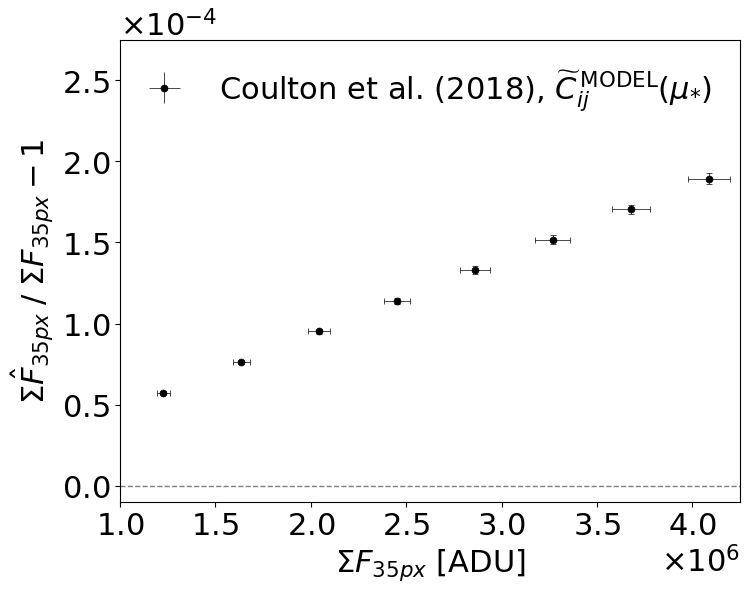

In [31]:
plt.figure(figsize=(8,6))
from matplotlib.pyplot import cm
import matplotlib
from scipy.stats import median_abs_deviation
colors = cm.viridis(np.linspace(5, 50, len(np.unique(exptimes))))
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('tableau-colorblind10')
def trim_to_smallest(arr1, arr2):
    maxind = np.min([len(arr1),len(arr2)])
    return arr1[0:maxind], arr2[0:maxind]

x_corrected, x = trim_to_smallest(mu_corrected,mu)
#x2_corrected, x2 = trim_to_smallest(mu2_corrected,mu2)
y = np.asarray(mu_corrected)/np.asarray(mu)
#y2 = np.asarray(mu2_corrected)/np.asarray(mu2)
#mask =  (y < 1.00025) * (y > 0.99997)
plt.rcParams.update({'font.size': 22})

def reject_outliers(data, m=10):
    from scipy.stats import median_abs_deviation
    
    return (np.abs(data - np.median(data)) < m * median_abs_deviation(data))

#print(np.unique(exptimes))
for i, t in enumerate(np.unique(exptimes)):
    if t < 15.:
        continue
    mask = (np.asarray(exptimes) == t)
    #print(t, len(y[mask]))
    
    #plt.plot([np.mean(np.asarray(x)[mask])], [np.mean(y[mask])], color="k", markersize=200)

    x_data=np.asarray(x)[mask]
    y_data=np.asarray(y)[mask] - 1.
    mask2 = reject_outliers(x_data) * reject_outliers(y_data)

    x_data = x_data[mask2]
    n = len(x_data)
    x_err = np.nanstd(x_data) #/ np.sqrt(n)
    y_data = y_data[mask2]
    y_err = np.nanstd(y_data) #/ np.sqrt(n)

    print(exptime,np.nanmean(y_data))
    #plt.scatter(x_data, y_data, s=2, c='k', alpha=0.2)
    print(np.nanmean(x_data), np.nanmean(y_data))
    plt.errorbar(np.nanmean(x_data), np.nanmean(y_data), 
                 xerr=x_err, yerr=y_err,
                 fmt="o", markersize=5,color="k", markeredgewidth=0.5,elinewidth=0.5, capthick=0.5, capsize=2)
    
# print(np.unique(exptimes))
# for i, t in enumerate(np.unique(exptimes)):
#     if t < 15.:
#         continue
#     mask = (np.asarray(exptimes) == t)
#     #print(t, len(y[mask]))
    
#     #plt.plot([np.mean(np.asarray(x)[mask])], [np.mean(y[mask])], color="k", markersize=200)

#     x_data=np.asarray(x2)[mask]
#     y_data=np.asarray(y2)[mask] - 1.
#     mask2 = reject_outliers(x_data) * reject_outliers(y_data)

#     x_data = x_data[mask2]
#     n = len(x_data)
#     x_err = np.nanstd(x_data) #/ np.sqrt(n)
#     y_data = y_data[mask2]
#     y_err = np.nanstd(y_data) #/ np.sqrt(n)
    
    
#     print(exptime,np.nanmean(y_data))
#     #plt.scatter(x_data, y_data, s=2, c='b', alpha=0.2)
#     #print(np.nanmean(x_data), np.nanmean(y_data))
#     plt.errorbar(np.nanmean(x_data), np.nanmean(y_data), 
#                  xerr=x_err, yerr=y_err,
#                  fmt="o", markerfacecolor="k", markersize=5,color="k", markeredgewidth=0.5, elinewidth=0.5, capthick=0.5, capsize=2)
    
    
# print(np.unique(exptimes))
# for i, t in enumerate(np.unique(exptimes)):
#     if t < 15.:
#         continue
#     mask = (np.asarray(exptimes) == t)
#     #print(t, len(y[mask]))
    
#     #plt.plot([np.mean(np.asarray(x)[mask])], [np.mean(y[mask])], color="k", markersize=200)

#     x_data=np.asarray(x3)[mask]
#     y_data=np.asarray(y3)[mask] - 1.
#     mask2 = reject_outliers(x_data) * reject_outliers(y_data)

#     x_data = x_data[mask2]
#     n = len(x_data)
#     x_err = np.nanstd(x_data) #/ np.sqrt(n)
#     y_data = y_data[mask2]
#     y_err = np.nanstd(y_data) #/ np.sqrt(n)
    
    
#     print(exptime,np.nanmean(y_data))
#     #plt.scatter(x_data, y_data, s=2, c='b', alpha=0.2)
#     #print(np.nanmean(x_data), np.nanmean(y_data))
#     plt.errorbar(np.nanmean(x_data), np.nanmean(y_data), 
#                  xerr=x_err, yerr=y_err,
#                  fmt="o", markerfacecolor="w", markersize=5,color="b", markeredgewidth=0.5, elinewidth=0.5, capthick=0.5, capsize=2)
    
# print(np.unique(exptimes))
# for i, t in enumerate(np.unique(exptimes)):
#     if t < 15.:
#         continue
#     mask = (np.asarray(exptimes) == t)
#     #print(t, len(y[mask]))
    
#     #plt.plot([np.mean(np.asarray(x)[mask])], [np.mean(y[mask])], color="k", markersize=200)

#     x_data=np.asarray(x4)[mask]
#     y_data=np.asarray(y4)[mask] - 1.
#     mask2 = reject_outliers(x_data) * reject_outliers(y_data)

#     x_data = x_data[mask2]
#     n = len(x_data)
#     x_err = np.nanstd(x_data) #/ np.sqrt(n)
#     y_data = y_data[mask2]
#     y_err = np.nanstd(y_data) #/ np.sqrt(n)
    
    
#     print(exptime,np.nanmean(y_data))
#     #plt.scatter(x_data, y_data, s=2, c='b', alpha=0.2)
#     #print(np.nanmean(x_data), np.nanmean(y_data))
#     plt.errorbar(np.nanmean(x_data), np.nanmean(y_data), 
#                  xerr=x_err, yerr=y_err,
#                  fmt="o", markerfacecolor="w", markersize=5,color="b", markeredgewidth=0.5, elinewidth=0.5, capthick=0.5, capsize=2)
    
plt.axhline(0.0, linestyle="--", linewidth=1., alpha=0.5, color="k")

plt.errorbar([], [], xerr=[], yerr=[], fmt="o", markerfacecolor="k", markersize=5,color="k", markeredgewidth=0.5, elinewidth=0.5, capthick=0.5, capsize=2, label=r'Coulton et al. (2018), $\widetilde{C}_{ij}^{\,\mathrm{MODEL}}(\mu_{*})$')
#plt.errorbar([], [], xerr=[], yerr=[], fmt="o", markersize=5,color="k", markeredgewidth=0.5,elinewidth=0.5, capthick=0.5, capsize=2, label="Coulton et al. (2018), \nFlux conserving\n(this work)")
#plt.errorbar([], [], xerr=[], yerr=[], fmt="o", markersize=5,color="b", markeredgewidth=0.5,elinewidth=0.5, capthick=0.5, capsize=2, label="Coulton et al. (2018), \nFlux conserving\n a matrix")
#plt.errorbar([], [], xerr=[], yerr=[], fmt="o", markersize=5,color="r", markeredgewidth=0.5,elinewidth=0.5, capthick=0.5, capsize=2, label="Coulton et al. (2018), \nFlux conserving\n a matrix force zero sum off")

#plt.colorbar(im,label="Exptime [s]")

m,b = np.polyfit(mu,y,1)

v = 0.01
plt.xlim(1.0e6,4.25e6)
plt.ylim(-0.1e-4,2.75e-4)
#plt.ylim(1-0.000001, 1+0.000001)
plt.xlabel("$\Sigma F_{35px}$ [ADU]")
plt.ylabel("$\Sigma \hat{F}_{35px}\;/\;\Sigma F_{35px} - 1$")
plt.xticks([1.0e6,1.5e6,2.0e6,2.5e6,3.0e6,3.5e6,4.0e6])
#plt.ticklabel_format(useOffset=False)
#from matplotlib.ticker import ScalarFormatter
#plt.gca().xaxis.set_major_formatter(ScalarFormatter('%.1f'))
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)
#plt.gca().set_xticklabels([str(round(float(label), 2)) for label in [1.0,2.0,3.0,4.0]])

plt.legend(frameon=False)
plt.savefig("../plots/chargeconservation.png", bbox_inches='tight')


OLD

In [14]:
dataset_refs = list(registry.queryDatasets(datasetType="gridSpotSrc", 
                                           collections=collections) )

mu2 = []
mu_corrected2 = []
x2 = []
x_corrected2 = []
reference2 = []
flux2 = []

exptimes2 = []
for i, ref in enumerate(dataset_refs):
    src = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.05.15/run_13248/R03-S12/uncorrected"])
    exptime = butler.get("raw", dataId=ref.dataId, collections=["u/abrought/BF/2023.05.15/run_13248/R03-S12/uncorrected"]).getMetadata()['EXPTIME']
    src_corrected = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.05.15/run_13248/R03-S12/corrected.optimized_scale_factor"])
    #spots_to_track, ind1, ind2 = np.intersect1d(src['spot_indices'], src_corrected['spot_indices'], return_indices=true)
    
    
    table = src.asAstropy()
    table_corrected = src_corrected.asAstropy()
    mask = cut(src)
    print(len(np.nonzero(mask)))
    
    exptimes2.extend([exptime for i in range(len(table['base_CircularApertureFlux_70_0_instFlux'][mask]))])
                     
    x2.extend(table['base_CircularApertureFlux_70_0_instFlux'][mask])
    mu2.extend(table['base_CircularApertureFlux_35_0_instFlux'][mask])

    if exptime == 5.0:
        reference.append( np.median(table['base_CircularApertureFlux_35_0_instFlux'][mask]) )
    
    mask2 = cut(src_corrected)
    x_corrected2.extend(table_corrected['base_CircularApertureFlux_70_0_instFlux'][mask2])
    mu_corrected2.extend(table_corrected['base_CircularApertureFlux_35_0_instFlux'][mask2])

    print(np.count_nonzero(mask), np.count_nonzero(mask2))

mean_reference = np.mean(reference2)
    

1
80 78


1
77 77


1
78 76


1
77 76


1
80 78


1
80 79


1
77 77


1
78 76


1
80 79


1
80 79


1
78 76


1
80 78


1
80 79


1
78 76


1
80 79


1
78 77


1
80 79


1
78 76


1
77 77


1
78 76


1
77 77


1
80 78


1
78 76


1
78 76


1
78 76


1
78 76


1
80 78


1
78 76


1
80 78


1
80 78


1
77 77


1
80 79


1
77 77


1
78 76


1
80 78


1
77 77


1
80 78


1
77 77


1
80 78


1
80 79


1
80 78


1
80 78


1
80 78


1
78 76


1
80 78


1
80 78


1
80 78


1
77 77


1
77 77


1
80 79


1
77 77


1
80 79


1
77 77


1
77 77


1
77 77


1
80 79


1
80 79


1
80 78


1
80 78


1
77 77


1
80 78


1
80 79


1
77 77


1
77 77


1
78 76


1
78 76


1
80 78


1
77 76


1
78 77


1
80 79


1
77 77


1
80 79


1
77 77


1
80 78


1
80 79


1
80 79


1
80 79


1
78 76


1
80 78


1
78 76


1
80 78


1
78 77


1
78 76


1
80 78


1
78 77


1
80 79


1
77 77


1
78 76


1
77 77


1
80 78


1
78 77


1
80 79


1
77 77


1
80 78


1
80 78


1
78 76


1
80 79


1
77 77


1
78 76


1
78 76


1
80 78


1
78 76


1
80 79


1
80 79


1
78 76


1
77 77


1
80 79


1
80 78


1
78 76


1
80 78


1
80 78


1
80 78


1
80 78


1
80 79


1
80 78


1
77 77


1
77 77


1
77 77


1
80 78


1
80 79


1
80 78


1
80 79


1
80 78


1
77 77


1
80 78


1
78 76


1
80 79


1
80 78


1
80 79


1
77 77


1
80 79


1
78 76


1
80 79


1
80 79


1
78 76


1
80 78


1
77 77


1
77 77


1
80 79


1
80 0


1
80 79


1
77 77


1
78 76


1
77 77


1
80 78


1
77 77


1
78 76


1
80 78


1
80 79


1
77 77


1
80 78


1
80 78


1
80 78


1
77 77


1
80 78


1
80 79


1
77 77


1
77 77


1
77 77


1
80 79


1
77 77


1
80 78


1
77 77


1
78 76


1
77 77


1
78 77


1
80 79


1
78 76


1
77 77


1
80 78


1
80 78


1
80 78


1
80 78


1
77 77


1
78 76


1
77 77


1
80 78


1
80 79


1
80 78


1
78 76


1
77 77


1
80 79


1
80 78


1
78 76


1
80 79


1
80 78


1
80 78


1
77 77


1
78 76


1
77 76


1
78 77


1
80 78


1
77 77


1
80 78


1
80 79


1
77 77


1
77 77


1
80 78


1
77 77


1
78 76


1
80 78


1
80 79


1
78 76


1
77 77


1
80 79


1
80 79


1
80 79


1
80 79


1
78 76


1
80 79


1
77 77


1
80 79


1
80 79


1
80 78


1
80 79


1
80 78


1
80 79


1
77 77


1
80 79


1
80 79


1
78 77


1
80 79


1
80 78


1
77 77


1
78 76


1
77 77


1
78 76


1
77 77


1
78 76


1
78 77


1
80 79


1
80 78


1
78 76


1
80 79


1
78 77


1
80 79


1
80 79


1
80 78


1
77 77


1
80 79


1
78 76


1
80 78


1
78 77


1
78 76


1
80 78


1
80 78


1
78 76


1
77 77


1
0 0


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
80 78


1
80 78


1
77 77


1
77 77


1
78 76


1
80 78


1
78 77


1
78 76


1
78 76


1
77 77


1
77 77


1
77 77


1
78 76


1
80 79


1
80 79


1
77 77


1
80 79


1
77 77


1
80 79


1
78 76


1
77 77


1
80 79


1
80 78


1
80 79


1
77 77


1
80 79


1
80 79


1
77 77


1
80 78


1
80 78


1
77 77


1
80 79


1
77 77


1
78 76


1
77 76


1
77 77


1
77 77


1
78 76


1
77 77


1
77 77


1
80 78


1
77 77


1
77 77


1
80 79


1
78 76


1
78 76


1
78 77


1
80 78


1
78 76


1
78 76


1
78 76


1
80 78


1
77 77


1
77 77


1
77 77


1
80 79


1
80 78


1
80 79


1
80 78


1
80 79


1
80 79


1
80 78


1
80 79


1
80 79


1
77 77


1
80 79


1
80 78


1
78 76


1
77 77


1
77 77


1
78 76


1
77 77


1
80 79


1
77 77


1
80 78


1
78 76


1
80 79


1
78 76


1
78 76


1
78 76


1
80 78


1
78 76


1
80 78


1
80 79


1
80 78


1
80 79


1
78 76


1
77 77


1
77 77


1
80 78


1
80 78


1
78 76


1
80 78


1
80 78


1
80 78


1
80 79


1
80 78


1
77 77


1
80 79


1
0 76


1
80 79


1
77 77


1
78 77


1
77 77


1
78 76


1
80 78


1
77 77


1
78 76


1
80 79


1
80 79


1
78 76


1
77 77


1
78 76


1
80 79


1
78 76


1
80 78


1
77 77


1
78 76


1
80 79


1
78 76


1
80 79


1
78 76


1
78 76


1
80 79


1
80 79


1
80 79


1
78 77


1
77 77


1
77 77


1
80 79


1
78 76


1
80 78


1
80 79


1
77 77


1
80 79


1
80 79


1
78 76


1
80 78


1
77 77


1
80 79


1
77 77


1
77 77


1
80 78


1
77 77


1
80 79


1
80 78


1
80 78


1
78 76


1
80 78


1
78 76


1
80 79


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
plt.figure(figsize=(8,6))
plt.style.use('tableau-colorblind10')
y2 = np.asarray(mu_corrected2)/np.asarray(mu2)
#mask =  (y < 1.00025) * (y > 0.99997)

print(np.unique(exptimes))
for t in np.unique(exptimes):
    mask =  (np.asarray(exptimes) == t)
    print(t, len(y2[mask]))
    plt.scatter(np.asarray(mu2)[mask], y2[mask], s=2, c=[t for i in range(len(y2[mask]))], alpha=0.2)
    plt.clim(5.0, 50.0)
    #plt.plot([np.mean(np.asarray(x)[mask])], [np.mean(y[mask])], color="k", markersize=200)
    plt.errorbar([np.mean(np.asarray(mu2)[mask])], [np.mean(y2[mask])], xerr=[np.std(np.asarray(mu2)[mask])], yerr=[np.std(y2[mask])],fmt="o", markersize=3.5,color="k", elinewidth=0.5, capthick=0.5, capsize=2)

plt.axhline(1.0, linestyle="--", linewidth=2, alpha=0.75, color="k")

plt.colorbar(label="Exptime [s]")

m,b = np.polyfit(mu2,y2,1)
print(m,b)
plt.ylim(1-0.0001, 1+0.0003)
plt.xlabel("$\Sigma F_{35px}$ [ADU]", fontsize=15)
plt.ylabel("$\Sigma \hat{F}_{35px}\;/\;\Sigma F_{35px}$", fontsize=15)
plt.yticks([1-0.0001,1+0,1+0.0001,1+0.0002, 1+0.0003])
plt.ticklabel_format(useOffset=False)
plt.savefig("../plots/chargeconservation.png", bbox_inches='tight')


ValueError: operands could not be broadcast together with shapes (30858,) (31338,) 

<Figure size 800x600 with 0 Axes>

In [7]:
dataset_refs = list(registry.queryDatasets(datasetType="gridSpotSrc", 
                                           collections=collections) )

mu = []
mu_corrected = []
x = []
x_corrected = []
reference = []
flux = []
exptimes = []

for i, ref in enumerate(dataset_refs):

    src = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/uncorrected_max100kE"])
    exptime = butler.get("raw", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/uncorrected_max100kE"]).getMetadata()['EXPTIME']
    src_corrected = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/corrected_max100kE_noQuadFit_corrModelr_3"])
    #spots_to_track, ind1, ind2 = np.intersect1d(src['spot_indices'], src_corrected['spot_indices'], return_indices=true)
    
    mdsrc = src.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    mask = cut(src)
    mdsrc = src_corrected.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    mask_corrected = cut(src_corrected)
    
    table = src.asAstropy()
    table_corrected = src_corrected.asAstropy()
    
    _, ind, ind_corrected = np.intersect1d(table['spotgrid_index'][mask], table_corrected['spotgrid_index'][mask_corrected], assume_unique=True, return_indices=True)
    
    table = table[mask][ind]
    table_corrected = table_corrected[mask_corrected][ind_corrected]
    
    
    x.extend(table['base_SdssShape_instFlux'])
    mu.extend(table['base_CircularApertureFlux_35_0_instFlux'])
    
    exptimes.extend([exptime for j in range(len(table['base_SdssCentroid_y']))])

    #if exptime == 5.0:
    #    reference.append( np.median(table['base_CircularApertureFlux_35_0_instFlux'][mask]) )
    
    x_corrected.extend(table_corrected['base_SdssShape_instFlux'])
    mu_corrected.extend(table_corrected['base_CircularApertureFlux_35_0_instFlux'])

    #flux.extend(table_corrected['base_SdssShape_instFlux'])


mean_reference = np.mean(reference)
    

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
plt.figure(figsize=(8,6))
plt.style.use('tableau-colorblind10')
y = np.asarray(mu_corrected)/np.asarray(mu)
mask =  (y < 1.00025) * (y > 0.99997)

print(np.unique(exptimes))
for t in np.unique(exptimes):
    mask =  (y < 1.00025) * (y > 0.99997) * (np.asarray(exptimes) == t)
    print(t, len(y[mask]))
    plt.scatter(np.asarray(mu)[mask], y[mask], s=2, c=[t for i in range(len(y[mask]))], alpha=0.2)
    plt.clim(5.0, 50.0)
    #plt.plot([np.mean(np.asarray(x)[mask])], [np.mean(y[mask])], color="k", markersize=200)
    plt.errorbar([np.mean(np.asarray(mu)[mask])], [np.mean(y[mask])], xerr=[np.std(np.asarray(mu)[mask])], yerr=[np.std(y[mask])],fmt="o", markersize=3.5,color="k", elinewidth=0.5, capthick=0.5, capsize=2)

plt.axhline(1.0, linestyle="--", linewidth=2, alpha=0.75, color="k")

plt.colorbar(label="Exptime [s]")

m,b = np.polyfit(mu,y,1)
print(m,b)
plt.ylim(1-0.0001, 1+0.0003)
plt.xlabel("$\Sigma F_{35px}$ [ADU]", fontsize=15)
plt.ylabel("$\Sigma \hat{F}_{35px}\;/\;\Sigma F_{35px}$", fontsize=15)
plt.yticks([1-0.0001,1+0,1+0.0001,1+0.0002, 1+0.0003])
plt.ticklabel_format(useOffset=False)
plt.savefig("../plots/chargeconservation.png", bbox_inches='tight')


In [11]:
# Flux cuts
def cut2(src, x0,y0,fluxCutThreshold=0.95, onlyConvergedGridFits=True):

    
    maxFlux = np.nanmax(src['base_SdssShape_instFlux'])
    thresh = np.percentile(src['base_SdssShape_instFlux'], fluxCutThreshold*100)
    #select = src['base_SdssShape_instFlux'] >= self.fluxCutThreshold*maxFlux
    #select = (src['base_SdssShape_instFlux'] >= thresh) & (src['spotgrid_index'] >= 0)
    #src  = src.subset(select)
    minradius = 22. * 65.
    distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
    distmask = distances >= minradius


    # Get only points with a converged grid fit:
    if onlyConvergedGridFits:
        ymask = (np.abs(src['base_SdssCentroid_y'] - src['spotgrid_y'])<2)
        xmask = (np.abs(src['base_SdssCentroid_x'] - src['spotgrid_x'])<2)

    
    
    mask = distmask & xmask & ymask
    #print("NUMPOINTS LEFT: ", len(src[mask]), "\n")
    
    return mask

In [15]:
dataset_refs = list(registry.queryDatasets(datasetType="gridSpotSrc", 
                                           collections=collections) )

mu = []
mu_corrected = []
x = []
x_corrected = []
reference = []
flux = []
exptimes = []

for i, ref in enumerate(dataset_refs):

    src = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/uncorrected_max100kE"])
    exptime = butler.get("raw", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/uncorrected_max100kE"]).getMetadata()['EXPTIME']
    src_corrected = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/corrected_max100kE_noQuadFit_corrModelr_3"])
    #spots_to_track, ind1, ind2 = np.intersect1d(src['spot_indices'], src_corrected['spot_indices'], return_indices=true)
    
    mdsrc = src.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    mask = cut2(src, x0,y0)
    mdsrc = src_corrected.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    mask_corrected = cut2(src_corrected,x0,y0)
    
    table = src.asAstropy()
    table_corrected = src_corrected.asAstropy()
    
    _, ind, ind_corrected = np.intersect1d(table['spotgrid_index'][mask], table_corrected['spotgrid_index'][mask_corrected], assume_unique=True, return_indices=True)
    
    table = table[mask][ind]
    table_corrected = table_corrected[mask_corrected][ind_corrected]
    
    
    x.extend(table['base_SdssCentroid_x'])
    mu.extend(table['base_SdssCentroid_y'])
    exptimes.extend([exptime for j in range(len(table['base_SdssCentroid_y']))])

    #if exptime == 5.0:
    #    reference.append( np.median(table['base_CircularApertureFlux_35_0_instFlux'][mask]) )
    
    x_corrected.extend(table_corrected['base_SdssCentroid_x'])
    mu_corrected.extend(table_corrected['base_SdssCentroid_y'])

    flux.extend(table_corrected['base_SdssShape_instFlux'])


mean_reference = np.mean(reference)
    

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]
5.0 2836
10.0 3005
15.0 3159
20.0 3073
25.0 3150
30.0 3150
35.0 3073
40.0 3150
45.0 3150
50.0 2833
-4.845238396360874e-05 0.109097478831749


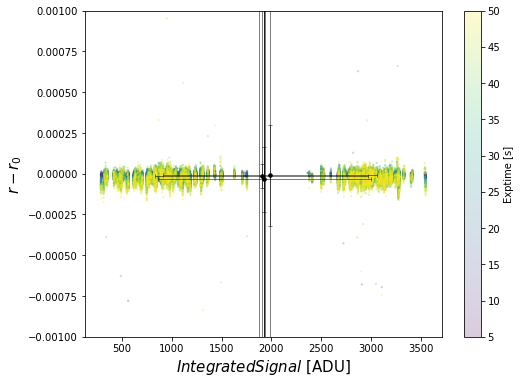

In [6]:
plt.figure(figsize=(8,6))
plt.style.use('tableau-colorblind10')
y = np.asarray(mu) - np.asarray(mu_corrected)
mask =  (y < 0.00020)

print(np.unique(exptimes))
for t in np.unique(exptimes):
    mask =  (np.asarray(exptimes) == t)
    print(t, len(y[mask]))
    plt.scatter(np.asarray(mu)[mask], y[mask], s=2, c=[t for i in range(len(y[mask]))], alpha=0.2)
    plt.clim(5.0, 50.0)
    #plt.plot([np.mean(np.asarray(x)[mask])], [np.mean(y[mask])], color="k", markersize=200)
    plt.errorbar([np.mean(np.asarray(mu)[mask])], [np.mean(y[mask])], xerr=[np.std(np.asarray(mu)[mask])], yerr=[np.std(y[mask])],fmt="o", markersize=3.5,color="k", elinewidth=0.5, capthick=0.5, capsize=2)

#plt.axhline(1.0, linestyle="--", linewidth=2, alpha=0.75, color="k")

plt.colorbar(label="Exptime [s]")

m,b = np.polyfit(mu,y,1)
print(m,b)
plt.ylim(-0.001, 0.001)
plt.xlabel("$Integrated Signal$ [ADU]", fontsize=15)
plt.ylabel("$r - r_0$", fontsize=15)
#plt.yticks([1-0.0001,1+0,1+0.0001,1+0.0002, 1+0.0003])
plt.ticklabel_format(useOffset=False)
plt.savefig("../plots/astrometry.png", bbox_inches='tight')


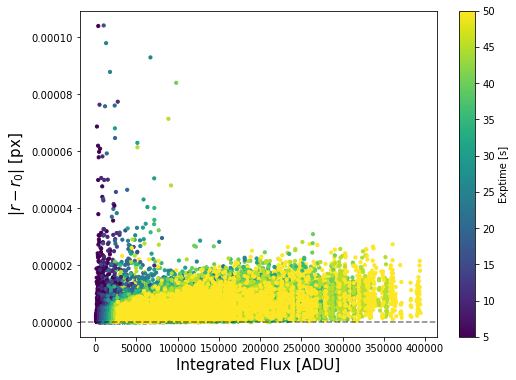

In [19]:
plt.figure(figsize=(8,6))
from matplotlib.pyplot import cm
color = cm.turbo(np.linspace(5, 50, len(np.unique(exptimes))))
r = np.sqrt((np.asarray(x)-np.asarray(x_corrected))**2 + (np.asarray(mu)-np.asarray(mu_corrected))**2)
y = np.abs(np.asarray(x)-np.asarray(x_corrected))
mask = (r < .0005)
#m, b = np.polyfit(np.asarray(flux)[mask], np.asarray(x)[mask]-np.asarray(x_corrected)[mask], deg=1)

plt.scatter(np.asarray(flux)[mask], r[mask],c=np.asarray(exptimes)[mask], s=10, label="x0")
for i, t in enumerate(np.unique(exptimes)):
    mask = (r < .0005) & (np.asarray(exptimes) == t)
    #plt.errorbar(np.mean(np.asarray(flux)[mask]), np.mean( r[mask]), xerr=np.std(np.asarray(flux)[mask]), yerr=np.std(r[mask]), fmt="o", markersize=5, color="k", capsize=5, elinewidth=1) 
#plt.scatter(flux, np.asarray(mu)-np.asarray(mu_corrected), label="y0")
plt.colorbar(label="Exptime [s]")
#plt.ylim(-0.0001, 0.0001)
plt.axhline(0.0, linestyle="--", color="k", alpha=0.5)
plt.xlabel("Integrated Flux [ADU]", fontsize=15)
plt.ylabel("$|r - r_0|$ [px]", fontsize=15)
#plt.ticklabel_format(useOffset=False)
plt.savefig("../plots/astrometry.png", bbox_inches="tight")


In [20]:
# Flux cuts
def cut2(src, x0,y0,fluxCutThreshold=0.95, onlyConvergedGridFits=True):

    
    maxFlux = np.nanmax(src['base_SdssShape_instFlux'])
    thresh = np.percentile(src['base_SdssShape_instFlux'], fluxCutThreshold*100)
    #select = src['base_SdssShape_instFlux'] >= self.fluxCutThreshold*maxFlux
    #select = (src['base_SdssShape_instFlux'] >= thresh) & (src['spotgrid_index'] >= 0)
    #src  = src.subset(select)
    minradius = 5. * 65.
    distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
    distmask = distances <= minradius


    # Get only points with a converged grid fit:
    if onlyConvergedGridFits:
        ymask = (np.abs(src['base_SdssCentroid_y'] - src['spotgrid_y'])<2)
        xmask = (np.abs(src['base_SdssCentroid_x'] - src['spotgrid_x'])<2)

    
    
    mask = distmask & xmask & ymask
    #print("NUMPOINTS LEFT: ", len(src[mask]), "\n")
    
    return mask

In [4]:
dataset_refs = list(registry.queryDatasets(datasetType="gridSpotSrc", 
                                           collections=collections) )

mu = []
mu_corrected = []
x = []
x_corrected = []
reference = []
flux = []
exptimes = []

for i, ref in enumerate(dataset_refs):

    src = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/uncorrected_max100kE"])
    exptime = butler.get("raw", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/uncorrected_max100kE"]).getMetadata()['EXPTIME']
    src_corrected = butler.get("gridSpotSrc", dataId=ref.dataId, collections=["u/abrought/BF/2023.01.26/run_13248/R03_S12/corrected_max100kE_noQuadFit_corrModelr_3"])
    #spots_to_track, ind1, ind2 = np.intersect1d(src['spot_indices'], src_corrected['spot_indices'], return_indices=true)
    
    mdsrc = src.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    mask = cut(src)
    mdsrc = src_corrected.getMetadata()
    x0 = mdsrc['GRID_X0']
    y0 = mdsrc['GRID_Y0']
    mask_corrected = cut(src_corrected)
    
    table = src.asAstropy()
    table_corrected = src_corrected.asAstropy()
    
    _, ind, ind_corrected = np.intersect1d(table['spotgrid_index'][mask], table_corrected['spotgrid_index'][mask_corrected], assume_unique=True, return_indices=True)
    
    table = table[mask][ind]
    table_corrected = table_corrected[mask_corrected][ind_corrected]
    
    
    x.extend(table['base_SdssCentroid_x'])
    mu.extend(table['base_SdssCentroid_y'])
    exptimes.extend([exptime for j in range(len(table['base_SdssCentroid_y']))])

    #if exptime == 5.0:
    #    reference.append( np.median(table['base_CircularApertureFlux_35_0_instFlux'][mask]) )
    
    x_corrected.extend(table_corrected['base_SdssCentroid_x'])
    mu_corrected.extend(table_corrected['base_SdssCentroid_y'])

    flux.extend(table_corrected['base_SdssShape_instFlux'])


mean_reference = np.mean(reference)
    

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


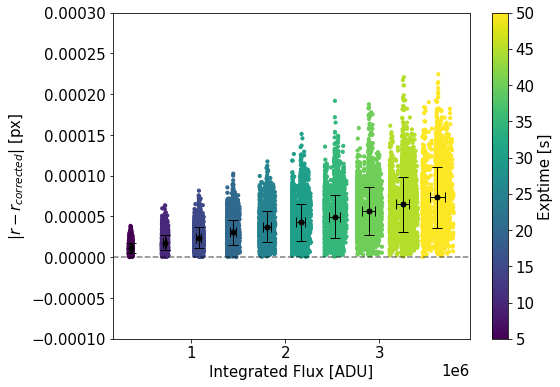

In [10]:
plt.figure(figsize=(8,6))
from matplotlib.pyplot import cm
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
color = cm.turbo(np.linspace(5, 50, len(np.unique(exptimes))))
r = np.sqrt((np.asarray(x)-np.asarray(x_corrected))**2 + (np.asarray(mu)-np.asarray(mu_corrected))**2)
y = np.abs(np.asarray(x)-np.asarray(x_corrected))
mask = (r < .0005)
#m, b = np.polyfit(np.asarray(flux)[mask], np.asarray(x)[mask]-np.asarray(x_corrected)[mask], deg=1)

plt.scatter(np.asarray(flux)[mask], r[mask],c=np.asarray(exptimes)[mask], s=10, label="x0")
for i, t in enumerate(np.unique(exptimes)):
    mask = (r < .0005) & (np.asarray(exptimes) == t)
    plt.errorbar(np.mean(np.asarray(flux)[mask]), np.mean( r[mask]), xerr=np.std(np.asarray(flux)[mask]), yerr=np.std(r[mask]), fmt="o", markersize=5, color="k", capsize=5, elinewidth=1) 
#plt.scatter(flux, np.asarray(mu)-np.asarray(mu_corrected), label="y0")
plt.colorbar(label="Exptime [s]")
plt.ylim(-0.0001, 0.0003)
plt.axhline(0.0, linestyle="--", color="k", alpha=0.5)
plt.xlabel("Integrated Flux [ADU]", fontsize=15)
plt.ylabel("$|r - r_{corrected}|$ [px]", fontsize=15)
#plt.ticklabel_format(useOffset=False)
plt.savefig("../plots/astrometry.png", bbox_inches="tight")
